# 📊 Prévision de la production hydro-électrique

Dans cette section, nous allons nous concentrer sur **la centrale hydro-électrique située dans la région de Montpellier**.  
L’objectif est de prédire la **production quotidienne d’énergie** à partir de données environnementales et hydrologiques locales.

- `date_obs_elab` : date de l’observation (YYYY-MM-DD)  
- `prod_hydro` : production d’énergie (kW)  


## Import 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from supabase import create_client
from dotenv import load_dotenv
import os

## 1. Chargement des données

In [54]:
df = pd.read_csv("~/production_enr/data/prod_hydro.csv")
display(df.head(6))

,date,prod_hydro
0,2022-09-01,78.517724
1,2022-09-02,67.981152
2,2022-09-03,62.904322
3,2022-09-04,84.443312
4,2022-09-05,77.390203
5,2022-09-06,0.000000


## 2. Dimensions et types de variables

In [55]:
df.dtypes

date           object
prod_hydro    float64
dtype: object

## 3. Valeurs manquantes

In [56]:
missing = df.isna().sum()

print(f"Missing values: {missing}")

Missing values: date          0
prod_hydro    0
dtype: int64


## 4. Statistiques descriptives

In [57]:
display(df.describe())

,prod_hydro
count,1125.000000
mean,113.006895
std,62.939009
min,0.000000
25%,68.413261
50%,95.399492
75%,183.745441
max,200.000000


## 5. Valeurs aberrantes
- **d’une centrale hydro (200 kW nominaux)**

### Le traitement des données provenant du fichier *CSV* et de *l’API* est présenté dans le dossier handlers/,
### dans le fichier datahandler.py.

## Model

### Je charge les donées de supabase

In [59]:
load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_SERVICE_ROLE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
data = supabase.table("Hydro_data").select("*").execute()
df = pd.DataFrame(data.data)
df

,id,date,prod_hydro,QmnJ,HIXnJ
0,1,2022-09-01T00:00:00,78.517724,690,372
1,2,2022-09-02T00:00:00,67.981152,630,360
2,3,2022-09-03T00:00:00,62.904322,600,342
3,4,2022-09-04T00:00:00,84.443312,632,377
4,5,2022-09-05T00:00:00,77.390203,604,345
...,...,...,...,...,...
875,876,2025-09-25T00:00:00,84.727227,669,366
876,877,2025-09-26T00:00:00,93.777966,667,362
877,878,2025-09-27T00:00:00,85.685576,673,364
878,879,2025-09-28T00:00:00,67.124681,686,364


### Préparation des données

In [60]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

X = df[["QmnJ", "HIXnJ"]]
y = df["prod_hydro"]

### Division en train/test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Entrainement du modèle

In [62]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Results

In [63]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² :", r2_score(y_test, y_pred))


MAE: 12.131544152798625
RMSE: 15.462135910515771
R² : 0.8967887754010017


### Visualisation

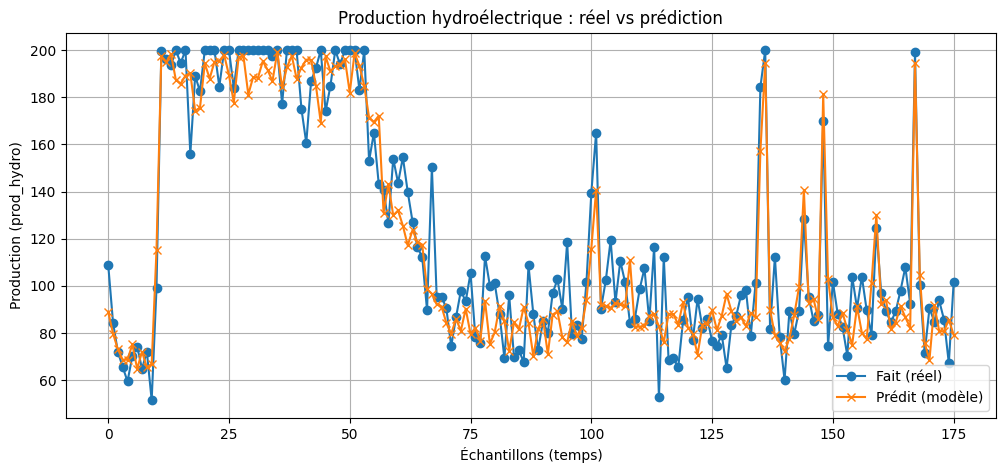

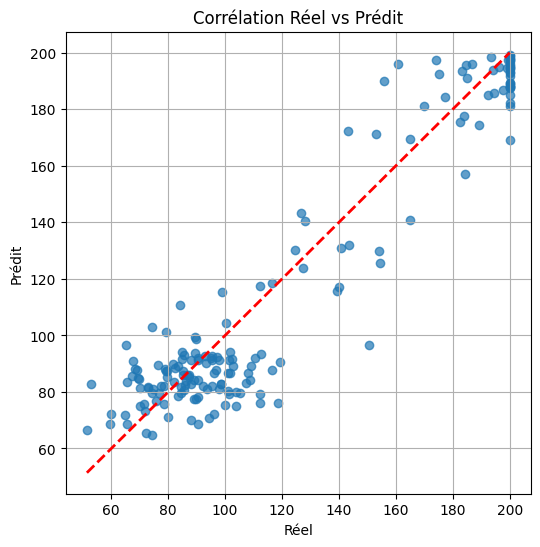

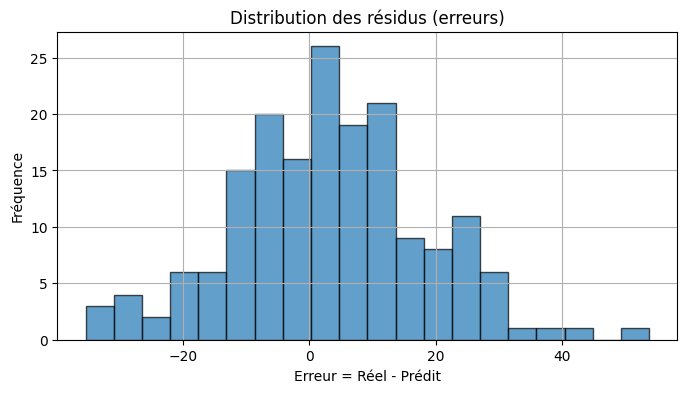

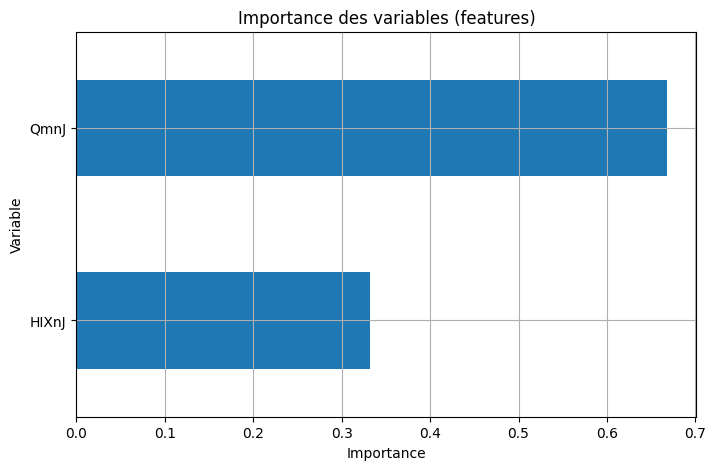

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Fait (réel)", marker='o')
plt.plot(y_pred, label="Prédit (modèle)", marker='x')
plt.title("Production hydroélectrique : réel vs prédiction")
plt.xlabel("Échantillons (temps)")
plt.ylabel("Production (prod_hydro)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Réel")
plt.ylabel("Prédit")
plt.title("Corrélation Réel vs Prédit")
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution des résidus (erreurs)")
plt.xlabel("Erreur = Réel - Prédit")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

if hasattr(model, "feature_importances_"):
    importance = pd.Series(model.feature_importances_, index=X_train.columns)
    importance = importance.sort_values(ascending=True)

    plt.figure(figsize=(8, 5))
    importance.plot(kind='barh')
    plt.title("Importance des variables (features)")
    plt.xlabel("Importance")
    plt.ylabel("Variable")
    plt.grid(True)
    plt.show()
